# Data Science project: CIRI

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tqdm
import os

from enum import Enum
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Parameters

In [2]:
# Whether model descriptors should be extracted for the baseline (True), or
# loaded from the filesystem (False).
# NOTE: "False" in combination with changes to the data split will result in
# inconsistencies errors further down in the document.
extract_model_descriptors = False

## Generic setup

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [3]:
cuda_enabled = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda_enabled else "cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [4]:
rng = np.random.default_rng(0)

We create the descriptors through transfer learning. We remove the last fully-connected (classification) layers of pre-trained models and use the output of the convolutional part of the respective model as descriptors. We do this for:

- VGG16

These models were chosen because of ... **TODO: List reasons for choosing models**

## Load datasets

Because the images were pre-processed in another notebook, they must now be loaded into this one. To do so, we use a custom class taken from https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658.

In [5]:
class prepped_data(torch.utils.data.Dataset):
    def __init__(self, img, mask):
        self.img = img  #img path
        self.mask = mask  #mask path
        self.len = len(os.listdir(self.img))

    def __getitem__(self, index):
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))

        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)

        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_tensor = torch.load(mask_file_path)

        return img_tensor, mask_tensor

    def __len__(self):
        return self.len

In [6]:
data_train = prepped_data('./content/train_loader/img', './content/train_loader/target')
data_test = prepped_data('./content/test_loader/img', './content/test_loader/target')

with open('./content/data_classes.bin', 'rb') as file:
    data_classes = pickle.load(file)

In [7]:
class DataType(Enum):
    TRAIN = "train"
    TEST = "test"


class Dataset:
    """
    Represents a dataset from which data, targets and dataloaders can be easily
    extracted. Used mostly as a Data Transfer Object to reduce the need to pass
    high numbers of parameters.
    """

    def __init__(self, data, classes):
        """
        Keyword arguments:
        data   -- dictionary of dataset labels mapped to corresponding Datasets
        classes -- a list of all classes that exist in the Datasets
        """
        self.data = data
        self.all_classes = classes

        self.targets = {}
        for label, data in self.data.items():
            self.targets[label] = self._get_targets(data)

        self.dataloaders = {}
        for label, data in self.data.items():
            self.dataloaders[label] = DataLoader(
                data,
                batch_size=4,
                shuffle=False
            )

    def _get_targets(self, data):
        return [target for (_, target) in data]


dataset = Dataset(
    {
        DataType.TRAIN: data_train,
        DataType.TEST: data_test
    },
    data_classes
)

## Initialize models

In [8]:
class Model():
    """
    Represents a generic convolutional model that is used for transfer
    learning, from which descriptors can be extracted for classification.
    """

    def __init__(self, model, name):
        self.model = model
        self.name = name

        for param in self.model.parameters():
            # As the model will not be trained, gradients are not required.
            # Disabling them speeds up performance.
            param.requires_grad = False

        self.model.eval()
        self.remove_classifier()

    def remove_classifier(self):
        """
        Removes the last fully connected layer (the classifier) from the
        model, allowing the extraction of descriptors.
        """
        raise NotImplementedError()

    def to(self, device):
        self.model = self.model.to(device)

    def descriptors(self, dataloader, as_numpy=True):
        """
        Returns the output of the model for all items in the dataloader.
        """
        outputs = []
        with torch.no_grad():
            for data, targets in tqdm.tqdm(dataloader):
                data = data.to(device)
                output = self.model(data).detach()
                outputs.extend(output)

        if as_numpy:
            outputs = np.array([output.cpu().numpy() for output in outputs])

        return outputs


models = []
if cuda_enabled:
    torch.cuda.empty_cache()

### VGG16

In [9]:
class Vgg16Model(Model):
    def __init__(self):
        model = torchvision.models.vgg16(weights="DEFAULT")
        super().__init__(model, "VGG16")

    def remove_classifier(self):
        self.model.classifier = nn.Identity()


vgg16 = Vgg16Model()
vgg16.to(device)

models.append(vgg16)

### Inception V3

In [10]:
class InceptionV3Model(Model):
    def __init__(self):
        model = torchvision.models.inception_v3(weights="DEFAULT")
        super().__init__(model, "InceptionV3")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


inception = InceptionV3Model()
inception.to(device)

models.append(inception)

## Baseline

### Obtain image descriptors

In [11]:
class DescriptorManager:
    """
    Handles the loading, saving and extraction of data descriptors.
    """

    def __init__(self, model, base_path="./data/descriptors", extract=False):
        self.model = model
        self.base_path = base_path
        self.extract = extract

    def create_path(self, label):
        """
        Creates a standardised path for descriptors with the provided model name
        and label to prevent inconsistencies between loading and saving descriptors.
        """
        return f"{self.base_path}/{self.model.name}/descriptors_{label}.bin"

    def safe_open_wb(self, path):
        """
        Open "path" for writing, creating any parent directories as needed.
        """
        os.makedirs(os.path.dirname(path), exist_ok=True)

        return open(path, 'wb')

    def save_descriptors(self, descriptors, label):
        """
        Saves the provided descriptor to the file system at a path derived from
        the model name and label.
        """
        path = self.create_path(label)
        with self.safe_open_wb(path) as file:
            pickle.dump(descriptors, file)

    def extract_save_descriptors(self, dataloader, label):
        """
        Extracts descriptors from the provided model and saves them to the
        file system.
        """
        descriptors = self.model.descriptors(dataloader, True)
        self.save_descriptors(descriptors, label)

        return descriptors

    def load_descriptors(self, label):
        """
        Loads and returns the provided descriptors from the file system, based
        on the provided model name and label.
        """
        path = self.create_path(label)
        with open(path, "rb") as file:
            return pickle.load(file)

    def get_descriptors(self, dataloader, label):
        """
        Returns descriptors from the file system or extracts them from the model,
        depending on the DescriptorManager "extract" property. Loading from the
        file system relies on the provided model.name andlabel.
        """
        if self.extract:
            return self.extract_save_descriptors(dataloader, label)

        return self.load_descriptors(label)

### Perform k-nearest neighbors (kNN) classification

First, we define the number of neighbors using which we would like to perform classification.

In [12]:
n_neighbors_list = [2, 3, 5, 8, 13, 18, 21, 34]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [13]:
class DescriptorAssessor:
    def __init__(self, descriptor_manager):
        self.descriptor_manager = descriptor_manager

    def _print_accuracies(self, accuracies, label):
        for n_neighbors, accuracy in accuracies.items():
            print(f"{self.model.name} accuracy on {label} set for {n_neighbors}-neighbor classification: {accuracy}")

    def _get_descriptors(self, dataset, data_types):
        descriptors = {}

        for data_type in data_types:
            descriptors[data_type] = self.descriptor_manager.get_descriptors(
                dataset.dataloaders[data_type],
                data_type
            )

        return descriptors

    def assess(self, dataset, n_neighbors_list, train_type, assess_types):
        """
        Assess the performance of kNN-classifiers on model descriptors for
        different numbers of neighbors.

        Keyword arguments:
        dataset -- dictionary of data types (train, test, ...) mapped to Subsets
        n_neighbors_list -- list of numbers of neighbors to assess
        train_type -- the data type to which the classifier should be fit
        assess_types -- the types on which to assess the classifier accuracy
        """
        descriptors = self._get_descriptors(
            dataset,
            assess_types
        )

        predictions = dict([(assess_type, {}) for assess_type in assess_types])
        accuracies = dict([(assess_type, {}) for assess_type in assess_types])

        for n_neighbors in n_neighbors_list:
            classifier = KNeighborsClassifier(n_neighbors=n_neighbors).fit(
                descriptors[train_type],
                dataset.targets[train_type]
            )

            for assess_type in assess_types:
                predictions[assess_type][n_neighbors] = classifier.predict(
                    descriptors[assess_type]
                )
                accuracies[assess_type][n_neighbors] = accuracy_score(
                    dataset.targets[assess_type],
                    predictions[assess_type][n_neighbors]
                )

        return (descriptors, predictions, accuracies)

In [14]:
class Visualiser:
    def __init__(self, model):
        self.model = model

    def _print_accuracies(self, accuracies, label):
        for n_neighbors, accuracy in accuracies.items():
            print(f"{self.model.name} accuracy on {label} set for {n_neighbors}-neighbor classification: {accuracy}")

    def _plot_accuracies(self, ax, accuracies, label):
        return ax.plot(
            accuracies.keys(),
            list(accuracies.values()),
            label=label,
            marker="o"
        )

    def visualise_accuracies_per_n(self, accuracies):
        fig, ax = plt.subplots()

        for assess_type, assess_type_accuracies in accuracies.items():
            self._print_accuracies(assess_type_accuracies, assess_type)
            self._plot_accuracies(ax, assess_type_accuracies, assess_type)

        ax.legend()
        ax.set_title(f"kNN-classification performance using {self.model.name} descriptors")
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("accuracy")
        plt.show()

VGG16 accuracy on DataType.TRAIN set for 2-neighbor classification: 0.923327664399093
VGG16 accuracy on DataType.TRAIN set for 3-neighbor classification: 0.7089002267573696
VGG16 accuracy on DataType.TRAIN set for 5-neighbor classification: 0.5488945578231292
VGG16 accuracy on DataType.TRAIN set for 8-neighbor classification: 0.4770408163265306
VGG16 accuracy on DataType.TRAIN set for 13-neighbor classification: 0.3227040816326531
VGG16 accuracy on DataType.TRAIN set for 18-neighbor classification: 0.28273809523809523
VGG16 accuracy on DataType.TRAIN set for 21-neighbor classification: 0.266156462585034
VGG16 accuracy on DataType.TRAIN set for 34-neighbor classification: 0.21386054421768708
VGG16 accuracy on DataType.TEST set for 2-neighbor classification: 0.2898550724637681
VGG16 accuracy on DataType.TEST set for 3-neighbor classification: 0.2554347826086957
VGG16 accuracy on DataType.TEST set for 5-neighbor classification: 0.22327898550724637
VGG16 accuracy on DataType.TEST set for 8

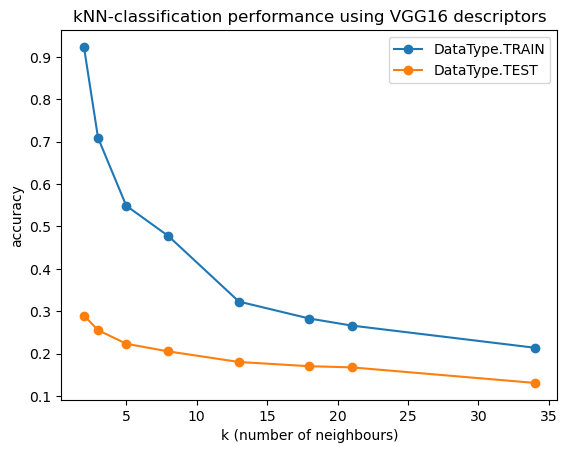

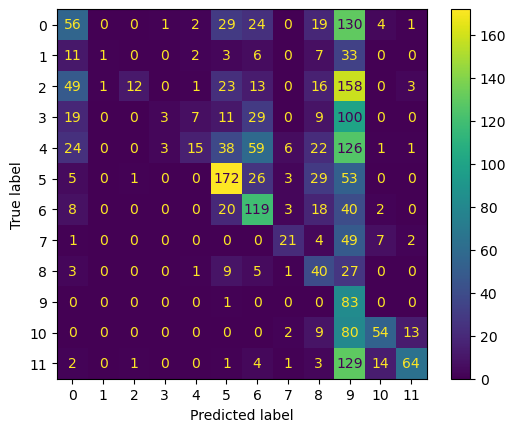

InceptionV3 accuracy on DataType.TRAIN set for 2-neighbor classification: 0.9005102040816326
InceptionV3 accuracy on DataType.TRAIN set for 3-neighbor classification: 0.8673469387755102
InceptionV3 accuracy on DataType.TRAIN set for 5-neighbor classification: 0.8204365079365079
InceptionV3 accuracy on DataType.TRAIN set for 8-neighbor classification: 0.7766439909297053
InceptionV3 accuracy on DataType.TRAIN set for 13-neighbor classification: 0.7406462585034014
InceptionV3 accuracy on DataType.TRAIN set for 18-neighbor classification: 0.7268990929705216
InceptionV3 accuracy on DataType.TRAIN set for 21-neighbor classification: 0.721655328798186
InceptionV3 accuracy on DataType.TRAIN set for 34-neighbor classification: 0.6917517006802721
InceptionV3 accuracy on DataType.TEST set for 2-neighbor classification: 0.5905797101449275
InceptionV3 accuracy on DataType.TEST set for 3-neighbor classification: 0.6005434782608695
InceptionV3 accuracy on DataType.TEST set for 5-neighbor classificati

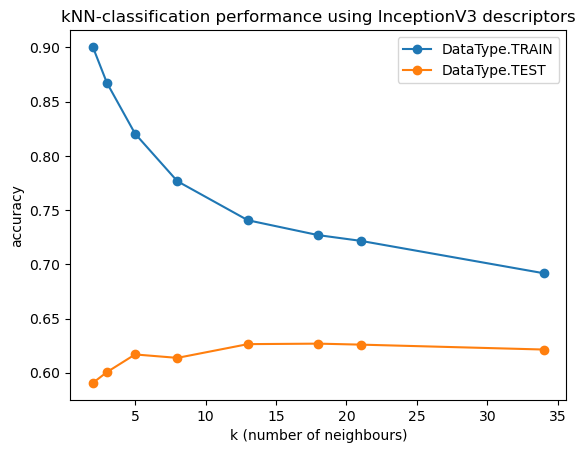

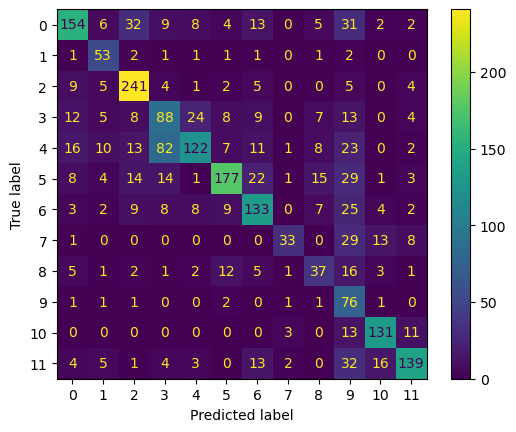

In [15]:
for model in models:
    descriptor_manager = DescriptorManager(
        model=model,
        extract=extract_model_descriptors
    )
    descriptor_assessor = DescriptorAssessor(descriptor_manager)

    descriptors, predictions, accuracies = descriptor_assessor.assess(
        dataset,
        n_neighbors_list,
        DataType.TRAIN,
        [DataType.TRAIN, DataType.TEST]
    )

    visualiser = Visualiser(model)
    visualiser.visualise_accuracies_per_n(
        accuracies
    )

    best_n_test = max(
        accuracies[DataType.TEST],
        key=accuracies[DataType.TEST].get
    )

    cm = confusion_matrix(
        dataset.targets[DataType.TEST],
        predictions[DataType.TEST][best_n_test]
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### Visually assess predicted vs. target through PCA

In [16]:
def plot_predictions_against_targets(fit_pca,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)